<a href="https://colab.research.google.com/github/CCIR-Academy/Techcamp2021S-Phase3/blob/main/Project__1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1: FinTech



## Intro
- In short, by FinTech we mean the practice of collecting and analyzing data from any financial/trading market with program or other form of automation as well as algorithms/strategies implemented by libraries.
- In some cases, we aim to generate detailed reports with in-depth observations and inferences for the sake of informing human decisions; in others, the goal is to administer automatic trading tracsactions on the basis of strategies and indexes.
- Traditionally, such practices are done with stock markets, but in this project we will instead practice with crytocurrencies such as Bitcoin and USDT for several reasons.
    - It's hot in terms of popularity and cool in terms of the technical details by which it's facilitated.
    - Markets of crytocurrencies evolve in a much more real-time manner and it is constantly open to trading.
1. Learn the general idea of how FinTech works, and master the basic skills required.
2. Take a walkthrough with some most basic and simplistic strategies to understand how to implement our own strategies into executable code.
3. Together in each team, students will be encouraged to design and compose the their own program with their own strategies, with which instructors would generate developmental feedback. 


### Preparation
1. Setup your local environment and get familiar with `freqtrade` and `freqUI` by following the instructions on [CCIR-Academy/TradingBot-Alive](https://github.com/CCIR-Academy/TradingBot-Alive).
2. Explore anything you find interesting on [Binance Academy](https://academy.binance.com/en). Recommended Readings include:
    - [Start Here](https://academy.binance.com/en/start-here)
    - [MACD Indicator Explained](https://academy.binance.com/en/articles/macd-indicator-explained)
    - [What Is the RSI Indicator?](https://academy.binance.com/en/articles/what-is-the-rsi-indicator)

### Expectations
1. Whereas this would very likely be the first experience of cryptocurrency and trading in general, the focus of this project is on understanding how to set up the runtime, generating simplistic customized indicators and strategies, and put everything together running smoothly. 
2. In other words, we do not tend to cover much on the actual algorithmic validity and the performance of strategies which entails substantial understanding and knowledge of trading, economics, and mathematics.
3. Expanding on this, we would strongly disagree if you plan to practice actual trading with authentic fiat currencies in the crytpcurrency trading business for the sake of implementing this project, and we will not concede to take any responsibility that might arise on the basis of such stance. 
4. Nonetheless, in order to fully experience the technical experience of crytocurrency trading, we have referenced to two approaches that could provide a somewhat complete trading experience:
    - With `freqtrade` and `backtest`, we can conduct backtesting with historical results.
    - With [Spot Test Network](https://testnet.binance.vision/), we can operate with the realtime data on the basis of a simulated account.

## Part 1: Exploration on Customized Strategy Implementation


In this part, we will try to generate a simplistic customized indicator on the basis of another classic indicator called "MACD". You can read much about this indicator on this page: [MACD Indicator Explained](https://academy.binance.com/en/articles/macd-indicator-explained)

### Example: DeltaMACD
- In very short illustration, MACD approach is acquired by calculating the differences between trading histories of a shorter period of time (usually 12 units of timeframe) and another of a longer period of time (usually 26 units of timerframe). 
- If MACD is positive, it suggests that during the shorter period of time the price is higher on exponential average in comparison to that of the longer period of time, which is perceived to be an indicator of an upward momentum in the changing price, and vice versa.

### Understanding the structure of the strategy class
The following code is the sample strategy created for this project with some minor changes in comparison to the default `SampleStrategy` created by using `freqtrade new-config --config config.json`.
The structure to use in constructing such kind of strategy is simple:
- It inherits from `IStrategy` which makes sure that it could be safely accepted by `freqtrade`.
- At the level of the strategies, strategy parameters can be set by directly setting the respective properties of the class, including (please read the comments inside the sample code for more detailed explanation) `timeframe`, `plot_config`, etc.
- We can implement our customized strategies by rewriting some of the class methods, such as:
    - `IStrategy.populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame` : This method is called when the latest data of the market has been successfully stored as the dataframe. By rewriting this method, we can construct and store customized indicators as new columns for the `dataframe`.
        - In our example, I attempt to construct a new index called `deltaMACD` which calculates the difference between the `MACD` of the active candle with that of the previous candle as I assume (by gut and without any mathematical evidence) a positive value of `deltaMACD` would predict the upward momentum more robustly. In order to do so, I added the following code before the method `populate_indicators` returns.
```python
        dataframe['macd_shift'] = dataframe.shift()['macd']
        dataframe['deltaMACD'] = dataframe['macd'] - dataframe['macd_shift']
        return dataframe
```
    dataframe.shift() would generate a copy of the dataframe but "shift" the whole dataframe in the indexes by one unit. You can learn more about how this method works by looking it up on Google.
    - `IStrategy.populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame`: This method is called when `freqtrade` want to determine whether it's a good time to buy more of the traded item. 
```python
dataframe.loc[
            (
                (dataframe['deltaMACD'] > 0) & #Make sure deltaMACD is above zero
                (dataframe['macd'] >0 ) & # Make sure macd is above zero
                (dataframe['volume'] > 0)  # Make sure Volume is not 0
            ),
            'buy'] = 1
```
    by using `dataframe.loc`, we can search for entries whose indicators meets the criteria that we determine as suggesting a good opportunity to buy more of the traded item, and edit the values in some of the columns of these entries in batch. In this case, we located a list of entries whose `deltaMACD`, `macd`, `volume` are all above zero, and set their value in the column `buy` as one, to label them as a good opportunity to buy.  

### Observe your strategy on `freqUI`
- As you properly installed and started `freqUI`, you can access `freqtrade` with a Web GUI at `http://localhost:8080/ ` (log in with the settings in `config.json`)
    - Make sure that `freqtrade` is running already.
- Get into the `Trade` modules from the navigators at the top of the page, and you will be able to see the graphs for the latest updates of price as well as the trading signals provided by your strategy.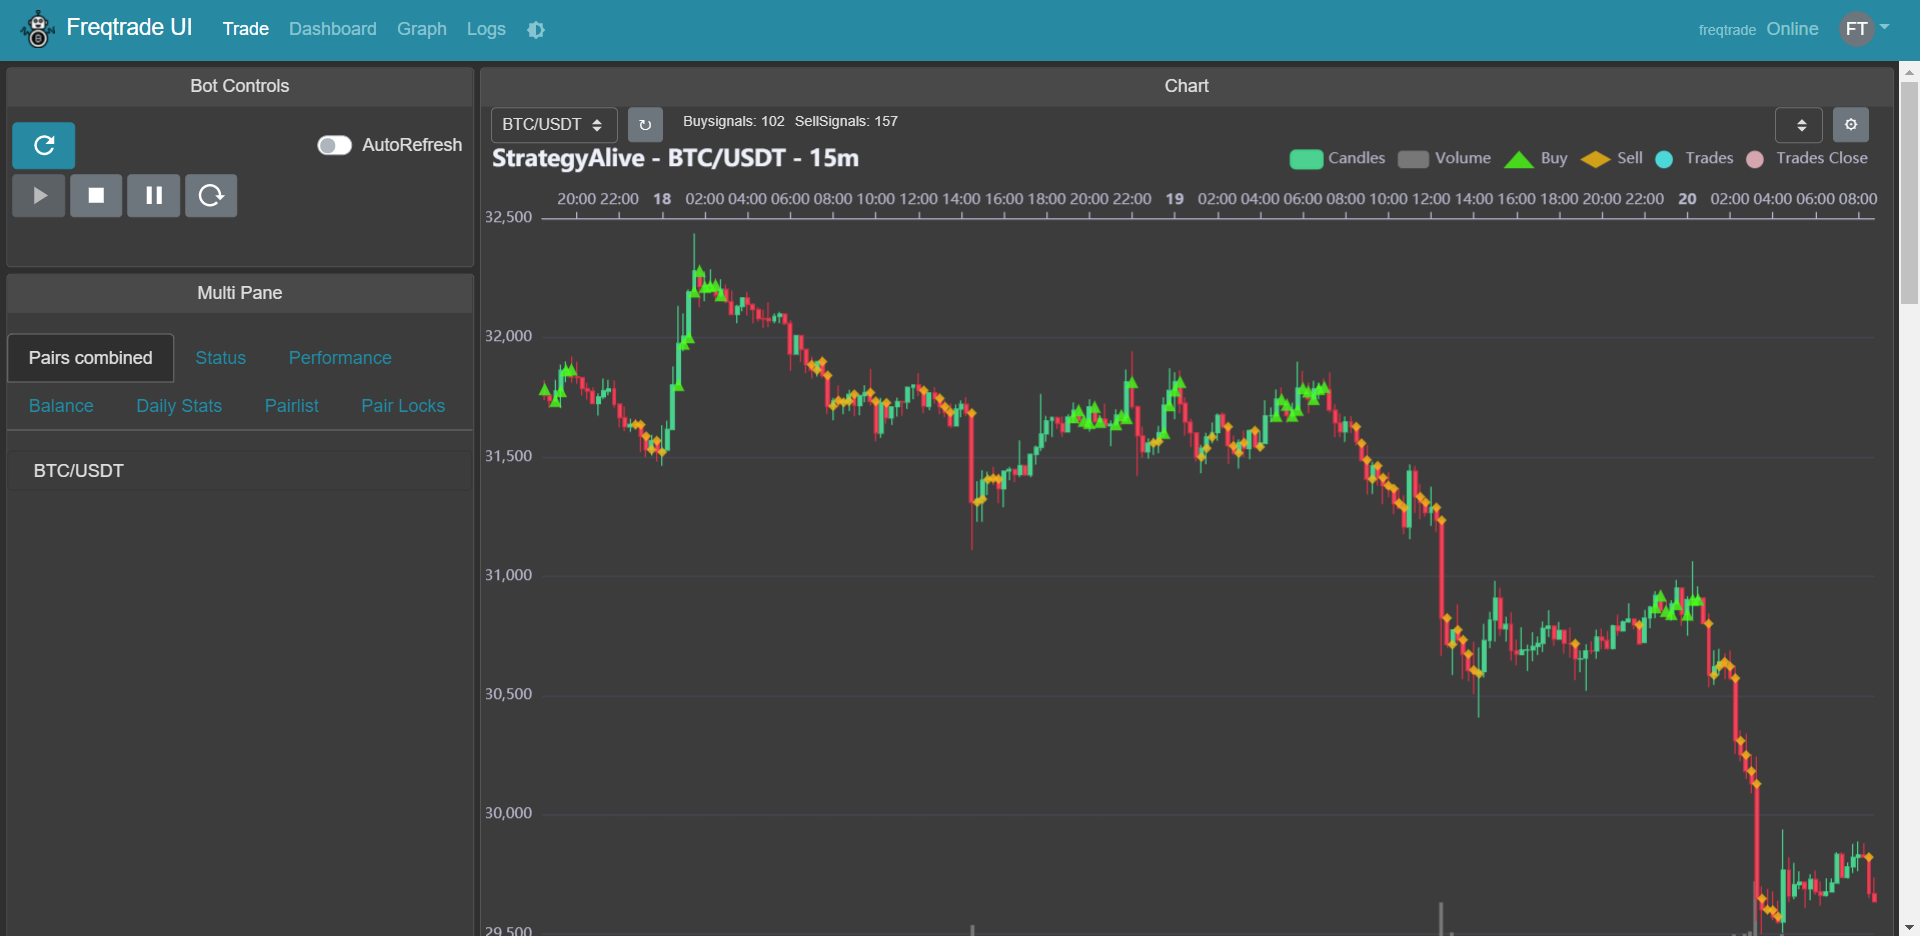


## Part 2: Backtesting
Backtesting refers to the practice of validating our strategies by simulating it with historical data, and we can observe the performance of these strategies based on the assumptions that the markets would operate with the same dynamics.
- Download data
```powershell
freqtrade download-data --days 365 -t 1m 5m 15m 30m 60m
```
    - May take a long time.
- After downloading the data, you can execute the following code to backtest your strategy on the downloaded data.
```powershell
freqtrade backtesting --strategy StrategyAlive --timeframe 15m
```
- If successfully done, a report would be generated and printed.


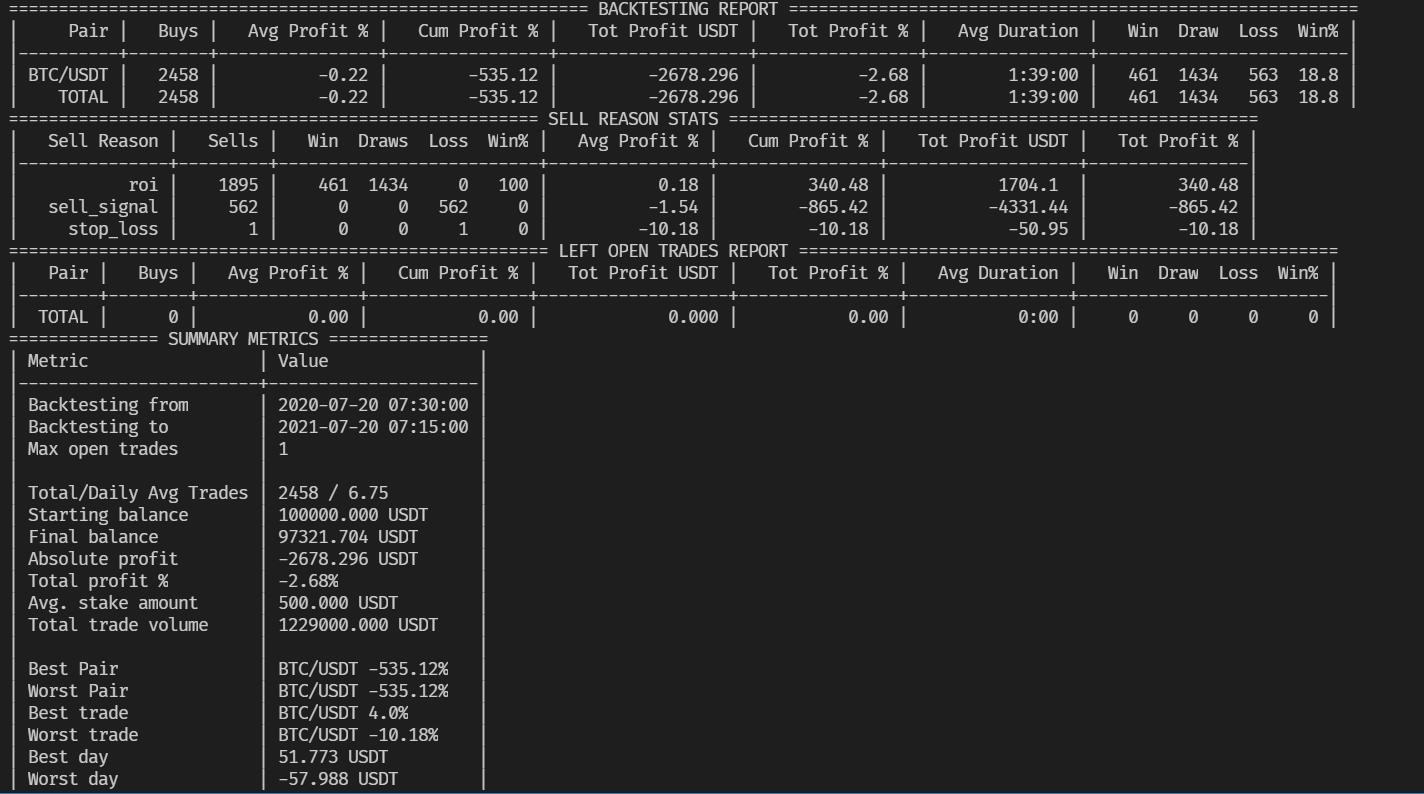

- It shouldn't have taken you too much time to see how terribly this simple strategy performs, but it could be for various reasons besides the strategy itself, such as the ROI settings, etc. Refer to https://www.freqtrade.io/en/stable/backtesting to see how you can improve your strategy against the historical data!

## Appendix: Sample Code (For the purpose of instruction and self-learning)

In [ ]:
class StrategyAlive(IStrategy):
    """
    This is a strategy template to get you started.
    More information in https://www.freqtrade.io/en/latest/strategy-customization/

    You can:
        :return: a Dataframe with all mandatory indicators for the strategies
    - Rename the class name (Do not forget to update class_name)
    - Add any methods you want to build your strategy
    - Add any lib you need to build your strategy

    You must keep:
    - the lib in the section "Do not remove these libs"
    - the methods: populate_indicators, populate_buy_trend, populate_sell_trend
    You should keep:
    - timeframe, minimal_roi, stoploss, trailing_*
    """
    # Strategy interface version - allow new iterations of the strategy interface.
    # Check the documentation or the Sample strategy to get the latest version.
    INTERFACE_VERSION = 2

    # Minimal ROI designed for the strategy.
    # This attribute will be overridden if the config file contains "minimal_roi".
    minimal_roi = {
        "60": 0.01,
        "30": 0.02,
        "0": 0.04
    }

    # Optimal stoploss designed for the strategy.
    # This attribute will be overridden if the config file contains "stoploss".
    stoploss = -0.10

    # Trailing stoploss
    trailing_stop = False
    # trailing_only_offset_is_reached = False
    # trailing_stop_positive = 0.01
    # trailing_stop_positive_offset = 0.0  # Disabled / not configured

    # Optimal timeframe for the strategy.
    timeframe = '15m'

    # Run "populate_indicators()" only for new candle.
    process_only_new_candles = False

    # These values can be overridden in the "ask_strategy" section in the config.
    use_sell_signal = True
    sell_profit_only = False
    ignore_roi_if_buy_signal = False

    # Number of candles the strategy requires before producing valid signals
    startup_candle_count: int = 30

    # Optional order type mapping.
    order_types = {
        'buy': 'limit',
        'sell': 'limit',
        'stoploss': 'market',
        'stoploss_on_exchange': False
    }

    # Optional order time in force.
    order_time_in_force = {
        'buy': 'gtc',
        'sell': 'gtc'
    }
    
    plot_config = {
        # Main plot indicators (Moving averages, ...)
        'main_plot': {
            # 'tema': {},
            # 'sar': {'color': 'white'},
        },
        'subplots': {
            # Subplots - each dict defines one additional plot
            "MACD": {
                'macd': {'color': 'pink'},
                'macdsignal': {'color': 'purple'},
                'deltaMACD': {
                    'color': 'orange',
                    'type': 'bar'
                },
            },
            "RSI": {
                'rsi': {'color': 'red'},
            },
        }
    }
    def informative_pairs(self):
        """
        Define additional, informative pair/interval combinations to be cached from the exchange.
        These pair/interval combinations are non-tradeable, unless they are part
        of the whitelist as well.
        For more information, please consult the documentation
        :return: List of tuples in the format (pair, interval)
            Sample: return [("ETH/USDT", "5m"),
                            ("BTC/USDT", "15m"),
                            ]
        """
        return []

    def populate_indicators(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
        """
        Adds several different TA indicators to the given DataFrame

        Performance Note: For the best performance be frugal on the number of indicators
        you are using. Let uncomment only the indicator you are using in your strategies
        or your hyperopt configuration, otherwise you will waste your memory and CPU usage.
        :param dataframe: Dataframe with data from the exchange
        :param metadata: Additional information, like the currently traded pair
        :return: a Dataframe with all mandatory indicators for the strategies
        """
        
        # Momentum Indicators
        # ------------------------------------

        # ADX
        dataframe['adx'] = ta.ADX(dataframe)

        # # Plus Directional Indicator / Movement
        # dataframe['plus_dm'] = ta.PLUS_DM(dataframe)
        # dataframe['plus_di'] = ta.PLUS_DI(dataframe)

        # # Minus Directional Indicator / Movement
        # dataframe['minus_dm'] = ta.MINUS_DM(dataframe)
        # dataframe['minus_di'] = ta.MINUS_DI(dataframe)

        # # Aroon, Aroon Oscillator
        # aroon = ta.AROON(dataframe)
        # dataframe['aroonup'] = aroon['aroonup']
        # dataframe['aroondown'] = aroon['aroondown']
        # dataframe['aroonosc'] = ta.AROONOSC(dataframe)

        # # Awesome Oscillator
        # dataframe['ao'] = qtpylib.awesome_oscillator(dataframe)

        # # Keltner Channel
        # keltner = qtpylib.keltner_channel(dataframe)
        # dataframe["kc_upperband"] = keltner["upper"]
        # dataframe["kc_lowerband"] = keltner["lower"]
        # dataframe["kc_middleband"] = keltner["mid"]
        # dataframe["kc_percent"] = (
        #     (dataframe["close"] - dataframe["kc_lowerband"]) /
        #     (dataframe["kc_upperband"] - dataframe["kc_lowerband"])
        # )
        # dataframe["kc_width"] = (
        #     (dataframe["kc_upperband"] - dataframe["kc_lowerband"]) / dataframe["kc_middleband"]
        # )

        # # Ultimate Oscillator
        # dataframe['uo'] = ta.ULTOSC(dataframe)

        # # Commodity Channel Index: values [Oversold:-100, Overbought:100]
        # dataframe['cci'] = ta.CCI(dataframe)

        # RSI
        dataframe['rsi'] = ta.RSI(dataframe)

        # # Inverse Fisher transform on RSI: values [-1.0, 1.0] (https://goo.gl/2JGGoy)
        # rsi = 0.1 * (dataframe['rsi'] - 50)
        # dataframe['fisher_rsi'] = (np.exp(2 * rsi) - 1) / (np.exp(2 * rsi) + 1)

        # # Inverse Fisher transform on RSI normalized: values [0.0, 100.0] (https://goo.gl/2JGGoy)
        # dataframe['fisher_rsi_norma'] = 50 * (dataframe['fisher_rsi'] + 1)

        # # Stochastic Slow
        # stoch = ta.STOCH(dataframe)
        # dataframe['slowd'] = stoch['slowd']
        # dataframe['slowk'] = stoch['slowk']

        # Stochastic Fast
        stoch_fast = ta.STOCHF(dataframe)
        dataframe['fastd'] = stoch_fast['fastd']
        dataframe['fastk'] = stoch_fast['fastk']

        # # Stochastic RSI
        # Please read https://github.com/freqtrade/freqtrade/issues/2961 before using this.
        # STOCHRSI is NOT aligned with tradingview, which may result in non-expected results.
        # stoch_rsi = ta.STOCHRSI(dataframe)
        # dataframe['fastd_rsi'] = stoch_rsi['fastd']
        # dataframe['fastk_rsi'] = stoch_rsi['fastk']

        # MACD
        macd = ta.MACD(dataframe)
        dataframe['macd'] = macd['macd']
        dataframe['macdsignal'] = macd['macdsignal']
        dataframe['macdhist'] = macd['macdhist']

        # MFI
        dataframe['mfi'] = ta.MFI(dataframe)

        # # ROC
        # dataframe['roc'] = ta.ROC(dataframe)

        # Overlap Studies
        # ------------------------------------

        # Bollinger Bands
        bollinger = qtpylib.bollinger_bands(qtpylib.typical_price(dataframe), window=20, stds=2)
        dataframe['bb_lowerband'] = bollinger['lower']
        dataframe['bb_middleband'] = bollinger['mid']
        dataframe['bb_upperband'] = bollinger['upper']
        dataframe["bb_percent"] = (
            (dataframe["close"] - dataframe["bb_lowerband"]) /
            (dataframe["bb_upperband"] - dataframe["bb_lowerband"])
        )
        dataframe["bb_width"] = (
            (dataframe["bb_upperband"] - dataframe["bb_lowerband"]) / dataframe["bb_middleband"]
        )

        # Bollinger Bands - Weighted (EMA based instead of SMA)
        # weighted_bollinger = qtpylib.weighted_bollinger_bands(
        #     qtpylib.typical_price(dataframe), window=20, stds=2
        # )
        # dataframe["wbb_upperband"] = weighted_bollinger["upper"]
        # dataframe["wbb_lowerband"] = weighted_bollinger["lower"]
        # dataframe["wbb_middleband"] = weighted_bollinger["mid"]
        # dataframe["wbb_percent"] = (
        #     (dataframe["close"] - dataframe["wbb_lowerband"]) /
        #     (dataframe["wbb_upperband"] - dataframe["wbb_lowerband"])
        # )
        # dataframe["wbb_width"] = (
        #     (dataframe["wbb_upperband"] - dataframe["wbb_lowerband"]) / dataframe["wbb_middleband"]
        # )

        # # EMA - Exponential Moving Average
        # dataframe['ema3'] = ta.EMA(dataframe, timeperiod=3)
        # dataframe['ema5'] = ta.EMA(dataframe, timeperiod=5)
        # dataframe['ema10'] = ta.EMA(dataframe, timeperiod=10)
        # dataframe['ema21'] = ta.EMA(dataframe, timeperiod=21)
        # dataframe['ema50'] = ta.EMA(dataframe, timeperiod=50)
        # dataframe['ema100'] = ta.EMA(dataframe, timeperiod=100)

        # # SMA - Simple Moving Average
        # dataframe['sma3'] = ta.SMA(dataframe, timeperiod=3)
        # dataframe['sma5'] = ta.SMA(dataframe, timeperiod=5)
        # dataframe['sma10'] = ta.SMA(dataframe, timeperiod=10)
        # dataframe['sma21'] = ta.SMA(dataframe, timeperiod=21)
        # dataframe['sma50'] = ta.SMA(dataframe, timeperiod=50)
        # dataframe['sma100'] = ta.SMA(dataframe, timeperiod=100)

        # Parabolic SAR
        dataframe['sar'] = ta.SAR(dataframe)

        # TEMA - Triple Exponential Moving Average
        dataframe['tema'] = ta.TEMA(dataframe, timeperiod=9)

        # Cycle Indicator
        # ------------------------------------
        # Hilbert Transform Indicator - SineWave
        hilbert = ta.HT_SINE(dataframe)
        dataframe['htsine'] = hilbert['sine']
        dataframe['htleadsine'] = hilbert['leadsine']

        # Pattern Recognition - Bullish candlestick patterns
        # ------------------------------------
        # # Hammer: values [0, 100]
        # dataframe['CDLHAMMER'] = ta.CDLHAMMER(dataframe)
        # # Inverted Hammer: values [0, 100]
        # dataframe['CDLINVERTEDHAMMER'] = ta.CDLINVERTEDHAMMER(dataframe)
        # # Dragonfly Doji: values [0, 100]
        # dataframe['CDLDRAGONFLYDOJI'] = ta.CDLDRAGONFLYDOJI(dataframe)
        # # Piercing Line: values [0, 100]
        # dataframe['CDLPIERCING'] = ta.CDLPIERCING(dataframe) # values [0, 100]
        # # Morningstar: values [0, 100]
        # dataframe['CDLMORNINGSTAR'] = ta.CDLMORNINGSTAR(dataframe) # values [0, 100]
        # # Three White Soldiers: values [0, 100]
        # dataframe['CDL3WHITESOLDIERS'] = ta.CDL3WHITESOLDIERS(dataframe) # values [0, 100]

        # Pattern Recognition - Bearish candlestick patterns
        # ------------------------------------
        # # Hanging Man: values [0, 100]
        # dataframe['CDLHANGINGMAN'] = ta.CDLHANGINGMAN(dataframe)
        # # Shooting Star: values [0, 100]
        # dataframe['CDLSHOOTINGSTAR'] = ta.CDLSHOOTINGSTAR(dataframe)
        # # Gravestone Doji: values [0, 100]
        # dataframe['CDLGRAVESTONEDOJI'] = ta.CDLGRAVESTONEDOJI(dataframe)
        # # Dark Cloud Cover: values [0, 100]
        # dataframe['CDLDARKCLOUDCOVER'] = ta.CDLDARKCLOUDCOVER(dataframe)
        # # Evening Doji Star: values [0, 100]
        # dataframe['CDLEVENINGDOJISTAR'] = ta.CDLEVENINGDOJISTAR(dataframe)
        # # Evening Star: values [0, 100]
        # dataframe['CDLEVENINGSTAR'] = ta.CDLEVENINGSTAR(dataframe)

        # Pattern Recognition - Bullish/Bearish candlestick patterns
        # ------------------------------------
        # # Three Line Strike: values [0, -100, 100]
        # dataframe['CDL3LINESTRIKE'] = ta.CDL3LINESTRIKE(dataframe)
        # # Spinning Top: values [0, -100, 100]
        # dataframe['CDLSPINNINGTOP'] = ta.CDLSPINNINGTOP(dataframe) # values [0, -100, 100]
        # # Engulfing: values [0, -100, 100]
        # dataframe['CDLENGULFING'] = ta.CDLENGULFING(dataframe) # values [0, -100, 100]
        # # Harami: values [0, -100, 100]
        # dataframe['CDLHARAMI'] = ta.CDLHARAMI(dataframe) # values [0, -100, 100]
        # # Three Outside Up/Down: values [0, -100, 100]
        # dataframe['CDL3OUTSIDE'] = ta.CDL3OUTSIDE(dataframe) # values [0, -100, 100]
        # # Three Inside Up/Down: values [0, -100, 100]
        # dataframe['CDL3INSIDE'] = ta.CDL3INSIDE(dataframe) # values [0, -100, 100]

        # # Chart type
        # # ------------------------------------
        # # Heikin Ashi Strategy
        # heikinashi = qtpylib.heikinashi(dataframe)
        # dataframe['ha_open'] = heikinashi['open']
        # dataframe['ha_close'] = heikinashi['close']
        # dataframe['ha_high'] = heikinashi['high']
        # dataframe['ha_low'] = heikinashi['low']

        # Retrieve best bid and best ask from the orderbook
        # ------------------------------------
        """
        # first check if dataprovider is available
        if self.dp:
            if self.dp.runmode.value in ('live', 'dry_run'):
                ob = self.dp.orderbook(metadata['pair'], 1)
                dataframe['best_bid'] = ob['bids'][0][0]
                dataframe['best_ask'] = ob['asks'][0][0]
        """
        dataframe['macd_shift'] = dataframe.shift()['macd']
        dataframe['deltaMACD'] = dataframe['macd'] - dataframe['macd_shift']
        return dataframe

    def populate_buy_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
        """
        Based on TA indicators, populates the buy signal for the given dataframe
        :param dataframe: DataFrame populated with indicators
        :param metadata: Additional information, like the currently traded pair
        :return: DataFrame with buy column
        """
        # dataframe.loc[
        #     (
        #         (qtpylib.crossed_above(dataframe['rsi'], 30)) &  # Signal: RSI crosses above 30
        #         (dataframe['tema'] <= dataframe['bb_middleband']) &  # Guard: tema below BB middle
        #         (dataframe['tema'] > dataframe['tema'].shift(1)) &  # Guard: tema is raising
        #         (dataframe['volume'] > 0)  # Make sure Volume is not 0
        #     ),
        #     'buy'] = 1
        dataframe.loc[
            (
                (dataframe['deltaMACD'] > 0) &
                (dataframe['macd'] >0 )# Signal: deltaMACD is above zero
                # (dataframe['tema'] <= dataframe['bb_middleband']) &  # Guard: tema below BB middle
                # (dataframe['tema'] > dataframe['tema'].shift(1)) &  # Guard: tema is raising
                # (dataframe['volume'] > 0)  # Make sure Volume is not 0
            ),
            'buy'] = 1
        return dataframe

    def populate_sell_trend(self, dataframe: DataFrame, metadata: dict) -> DataFrame:
        """
        Based on TA indicators, populates the sell signal for the given dataframe
        :param dataframe: DataFrame populated with indicators
        :param metadata: Additional information, like the currently traded pair
        :return: DataFrame with buy column
        """
        dataframe.loc[
            (
                (dataframe['deltaMACD'] < 0) &
                (dataframe['macd'] <0 )# Signal: deltaMACD is above zero
                # (dataframe['tema'] <= dataframe['bb_middleband']) &  # Guard: tema below BB middle
                # (dataframe['tema'] > dataframe['tema'].shift(1)) &  # Guard: tema is raising
                # (dataframe['volume'] > 0)  # Make sure Volume is not 0
            ),
            'sell'] = 1
        return dataframe
